In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input,Activation
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 100



In [3]:
# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

11501568/11490434 [==============================] - 1s 0us/step


In [0]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

In [0]:
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(Activation('relu'))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(Activation('relu'))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=adam)

In [0]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=adam)


In [0]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy',metrics=['accuracy'],  optimizer=adam)

dLosses = []
gLosses = []
disc_Loss=[]
disc_acc=[]
gen_Loss=[]
gen_acc=[]

In [0]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(disc_Loss, label='Discriminitive loss')
    plt.plot(gen_Loss, label='Generative loss')
    plt.plot(disc_acc, label='Discriminitive accuracy')
    plt.plot(gen_acc, label='Generative accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss and Accuracy')
    plt.legend()
    #plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

In [0]:
# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    print('-------------NEXT-------------')    
    plt.tight_layout()
    #plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)

In [0]:
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)

def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    for e in xrange(1, epochs+1):
        print '-'*15, 'Epoch %d' % e, '-'*15
        for _ in tqdm(xrange(batchCount)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        a=[]
        b=[]
        a=dloss
        b=gloss
        dLosses.append(a)
        gLosses.append(b)
        print(dLosses)
        print(gLosses)

        if e == 1 or e % 5 == 0:
            plotGeneratedImages(e)
            #saveModels(e)

    # Plot losses from every epoch

    for i in range(len(dLosses)):
      disc_Loss.append(dLosses[i][0])
      
      

    for i in range(len(dLosses)):
      disc_acc.append(dLosses[i][1])
      

    for i in range(len(gLosses)):
      gen_Loss.append(gLosses[i][0])
      
      

    for i in range(len(gLosses)):
      gen_acc.append(gLosses[i][1])
        
    plotLoss(e)

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 51
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:37<00:00, 12.45it/s]


[[0.63918793, 0.43359375]]
[[0.9553412, 0.1171875]]
-------------NEXT-------------


  0%|          | 1/468 [00:00<00:46,  9.99it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/468 [00:00<00:32, 14.49it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625]]
--------------- Epoch 3 ---------------


  0%|          | 2/468 [00:00<00:32, 14.43it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625]]
--------------- Epoch 4 ---------------


  0%|          | 2/468 [00:00<00:32, 14.40it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375]]
--------------- Epoch 5 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.43it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875]]
-------------NEXT-------------


  0%|          | 1/468 [00:00<00:47,  9.80it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:32, 14.14it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625]]
--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:32, 14.27it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375]]
--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:32, 14.16it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375]]
--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:32, 14.38it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625]]
--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:33<00:00, 13.01it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375]]
-------------NEXT-------------


  0%|          | 2/468 [00:00<00:35, 13.25it/s]

--------------- Epoch 11 ---------------


  0%|          | 2/468 [00:00<00:32, 14.31it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875]]
--------------- Epoch 12 ---------------


  0%|          | 2/468 [00:00<00:32, 14.15it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625]]
--------------- Epoch 13 ---------------


  0%|          | 2/468 [00:00<00:32, 14.52it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625]]
--------------- Epoch 14 ---------------


  0%|          | 2/468 [00:00<00:31, 14.57it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875]]
--------------- Epoch 15 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.31it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375]]
-------------NEXT-------------


  0%|          | 2/468 [00:00<00:44, 10.38it/s]

--------------- Epoch 16 ---------------


  0%|          | 2/468 [00:00<00:32, 14.29it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875]]
--------------- Epoch 17 ---------------


  0%|          | 2/468 [00:00<00:32, 14.49it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0.3203125]]
--------------- Epoch 18 ---------------


  0%|          | 2/468 [00:00<00:32, 14.21it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0.3203125], [1.0398886, 0.2109375]]
--------------- Epoch 19 ---------------


  0%|          | 2/468 [00:00<00:32, 14.37it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0.3203125], [1.0398886, 0.2109375], [0.89573705, 0.2890625]]
--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.15it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0.3203125], [1.0398886, 0.2109375], [0.89573705, 0.2890625], [0.91499156, 0.2890625]]
-------------NEXT-------------


  0%|          | 1/468 [00:00<00:47,  9.81it/s]

--------------- Epoch 21 ---------------


  0%|          | 2/468 [00:00<00:32, 14.46it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0.3203125], [1.0398886, 0.2109375], [0.89573705, 0.2890625], [0.91499156, 0.2890625], [0.9829185, 0

  0%|          | 2/468 [00:00<00:32, 14.54it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0.3203125], [1.0398886, 0.2109375], [0.89573705, 0.2890625], [0.91499156, 

  0%|          | 2/468 [00:00<00:32, 14.46it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0.3203125], [1.0398886, 0.2109375], [0.89573705, 0

  0%|          | 2/468 [00:00<00:32, 14.37it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0.3203125], [1.0398886, 0

100%|██████████| 468/468 [00:33<00:00, 14.34it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 0.3046875], [0.93430346, 0

  0%|          | 2/468 [00:00<00:43, 10.64it/s]

--------------- Epoch 26 ---------------


  0%|          | 2/468 [00:00<00:32, 14.36it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.1330863, 0.09375], [0.87288755, 

  0%|          | 2/468 [00:00<00:32, 14.54it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.0165564, 0.1796875], [1.133086

  0%|          | 2/468 [00:00<00:32, 14.44it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.2211453, 0.0625], [1.01655

  0%|          | 2/468 [00:00<00:33, 14.10it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.95531905, 0.2265625], [1.

100%|██████████| 468/468 [00:32<00:00, 14.25it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], [0.9655552, 0.21875], [0.9

  0%|          | 2/468 [00:00<00:44, 10.54it/s]

--------------- Epoch 31 ---------------


  0%|          | 2/468 [00:00<00:33, 13.88it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [1.0204647, 0.1484375], 

  0%|          | 2/468 [00:00<00:32, 14.35it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [1.0763633, 0.140625], [

  0%|          | 2/468 [00:00<00:32, 14.39it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [0.99747294, 0.1484375], [

  0%|          | 2/468 [00:00<00:32, 14.40it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [0.9516654, 0.109375], [

100%|██████████| 468/468 [00:32<00:00, 14.27it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875], [0.7567479, 0.390625], [

  0%|          | 2/468 [00:00<00:43, 10.80it/s]

--------------- Epoch 36 ---------------


  0%|          | 2/468 [00:00<00:32, 14.49it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375], [0.90785414, 0.1796875]

  0%|          | 2/468 [00:00<00:32, 14.36it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.15625], [0.8445852, 0.234375

  0%|          | 2/468 [00:00<00:32, 14.29it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625]]
[[0.9553412, 0.1171875], [0.91438556, 0.140625], [0.87690246, 0.1562

  0%|          | 2/468 [00:00<00:32, 14.47it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125]]
[[0.9553412, 0.1171875], [0.91438556, 0.1406

100%|██████████| 468/468 [00:33<00:00, 14.09it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875]]
[[0.9553412, 0.1171

  0%|          | 1/468 [00:00<00:47,  9.85it/s]

--------------- Epoch 41 ---------------


  0%|          | 2/468 [00:00<00:32, 14.47it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

  0%|          | 2/468 [00:00<00:32, 14.44it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

  0%|          | 2/468 [00:00<00:31, 14.67it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

  0%|          | 2/468 [00:00<00:32, 14.45it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

100%|██████████| 468/468 [00:32<00:00, 14.08it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

  0%|          | 2/468 [00:00<00:44, 10.44it/s]

--------------- Epoch 46 ---------------


  0%|          | 2/468 [00:00<00:32, 14.38it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

  0%|          | 2/468 [00:00<00:32, 14.31it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

  0%|          | 2/468 [00:00<00:32, 14.31it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

  0%|          | 2/468 [00:00<00:32, 14.22it/s]

[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

100%|██████████| 468/468 [00:32<00:00, 14.16it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

  0%|          | 2/468 [00:00<00:41, 11.35it/s]

--------------- Epoch 51 ---------------


100%|██████████| 468/468 [00:32<00:00, 14.22it/s]


[[0.63918793, 0.43359375], [0.6328594, 0.44140625], [0.6726769, 0.41015625], [0.6798434, 0.39453125], [0.63844824, 0.41796875], [0.6842708, 0.48046875], [0.6507542, 0.4453125], [0.62645304, 0.37890625], [0.6188847, 0.3984375], [0.6330224, 0.43359375], [0.6272699, 0.4375], [0.64323527, 0.3046875], [0.6326504, 0.34375], [0.63118505, 0.3125], [0.6136922, 0.37890625], [0.62660044, 0.39453125], [0.6217535, 0.453125], [0.6405156, 0.3359375], [0.6251269, 0.4296875], [0.63369876, 0.390625], [0.6265979, 0.359375], [0.6323674, 0.44140625], [0.6458666, 0.4140625], [0.6155788, 0.34765625], [0.6515496, 0.4140625], [0.62485904, 0.30078125], [0.62851447, 0.36328125], [0.6465655, 0.32421875], [0.62058514, 0.41015625], [0.59227204, 0.390625], [0.64427584, 0.41015625], [0.62478316, 0.40625], [0.6354883, 0.484375], [0.63588154, 0.3828125], [0.63483316, 0.34375], [0.61599314, 0.39453125], [0.62277555, 0.43359375], [0.6332705, 0.3515625], [0.6487103, 0.3828125], [0.6493845, 0.35546875], [0.6081081, 0.39843

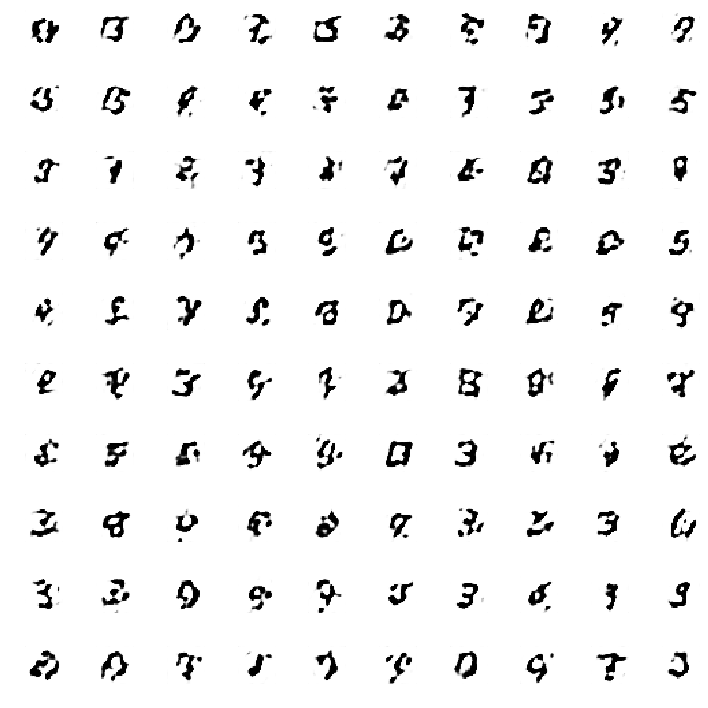

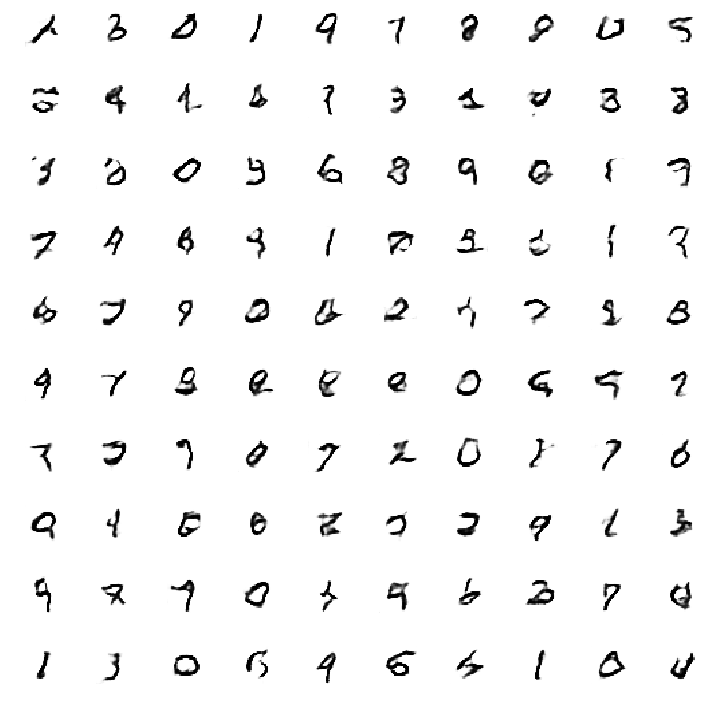

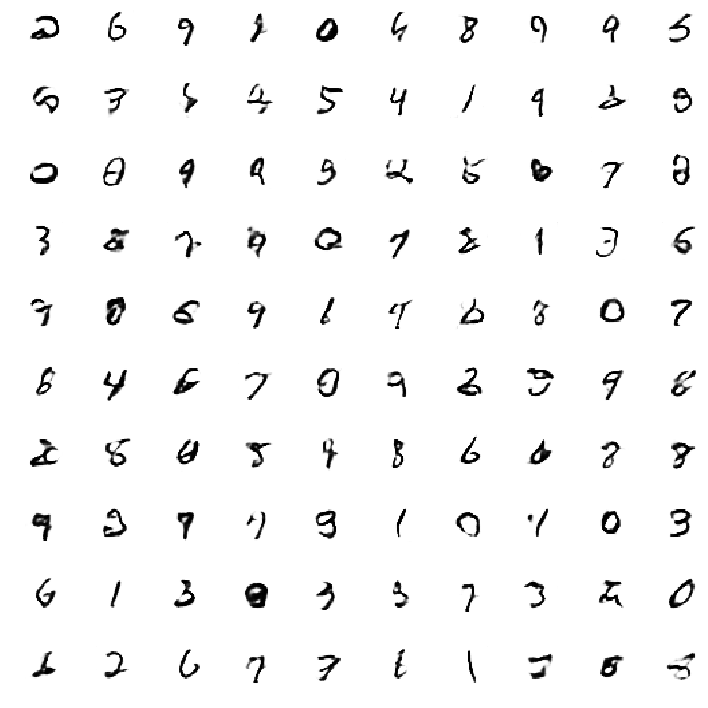

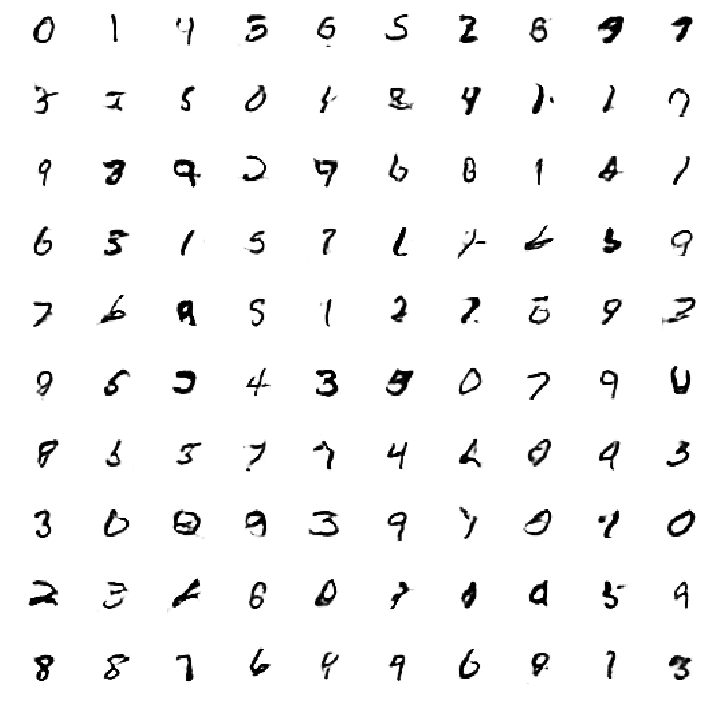

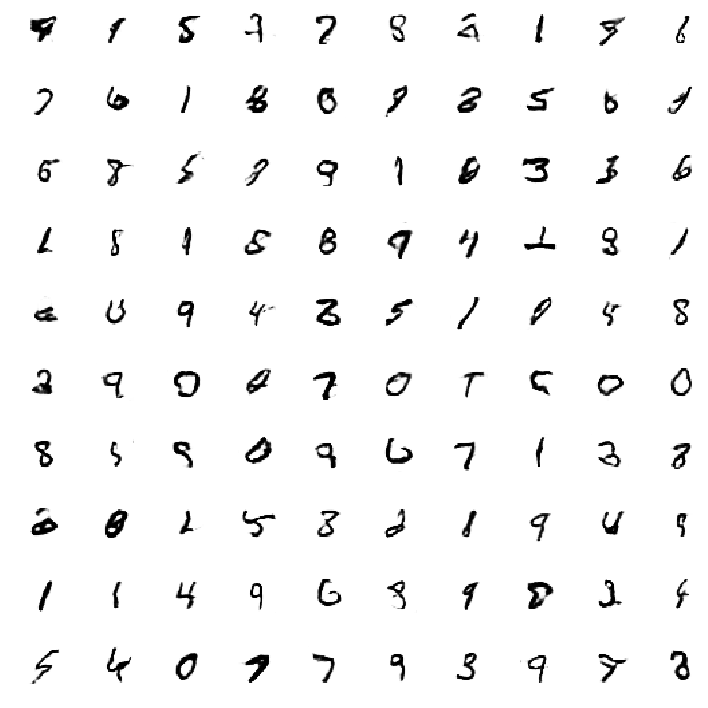

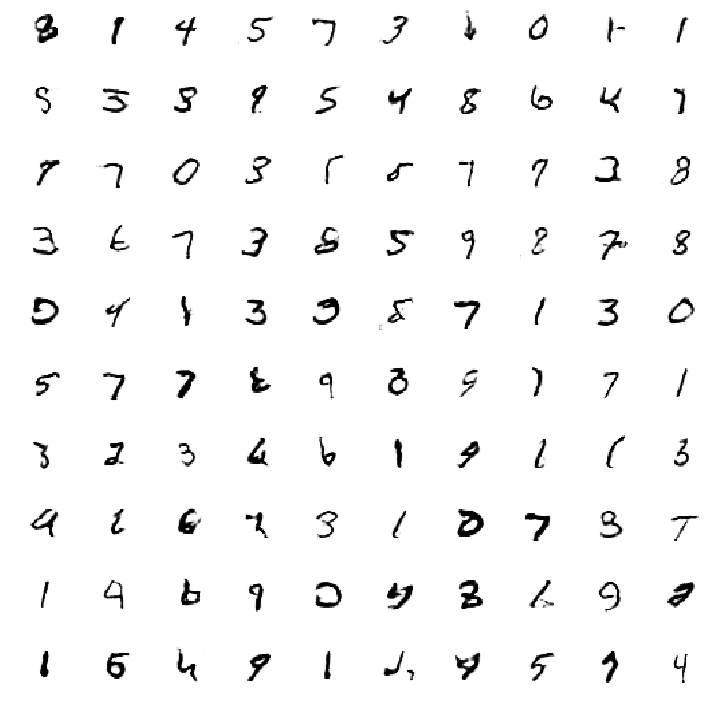

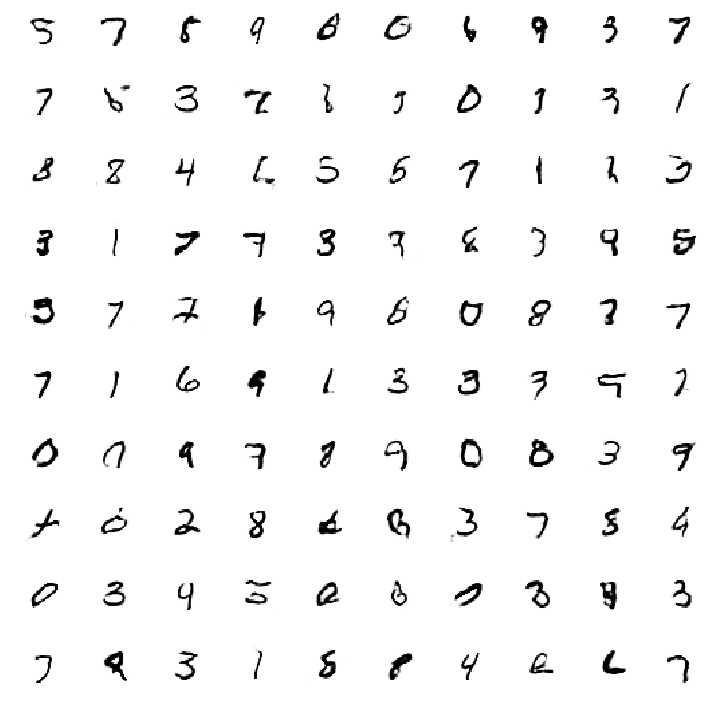

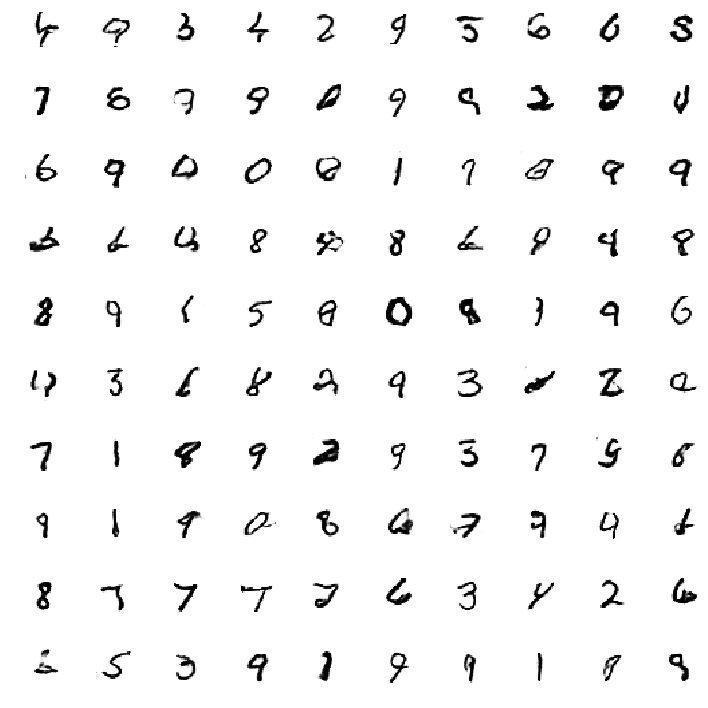

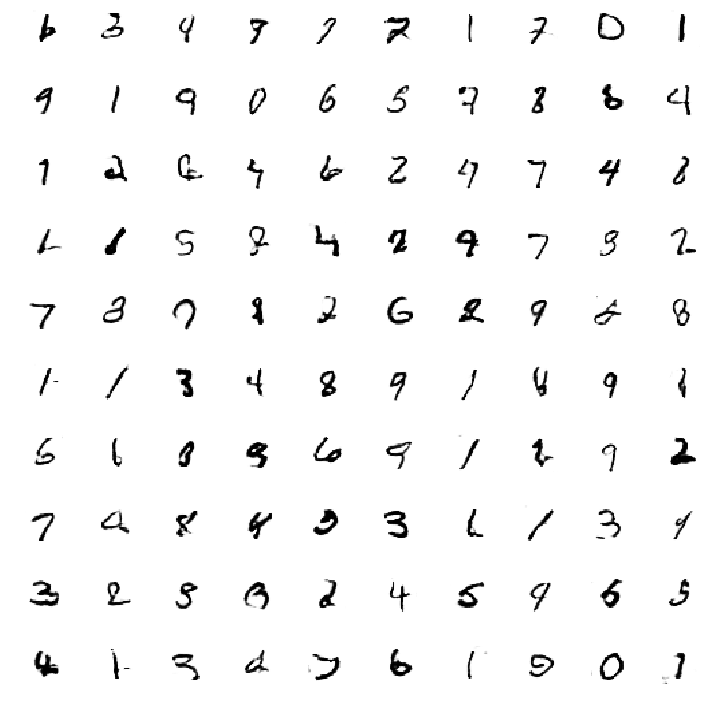

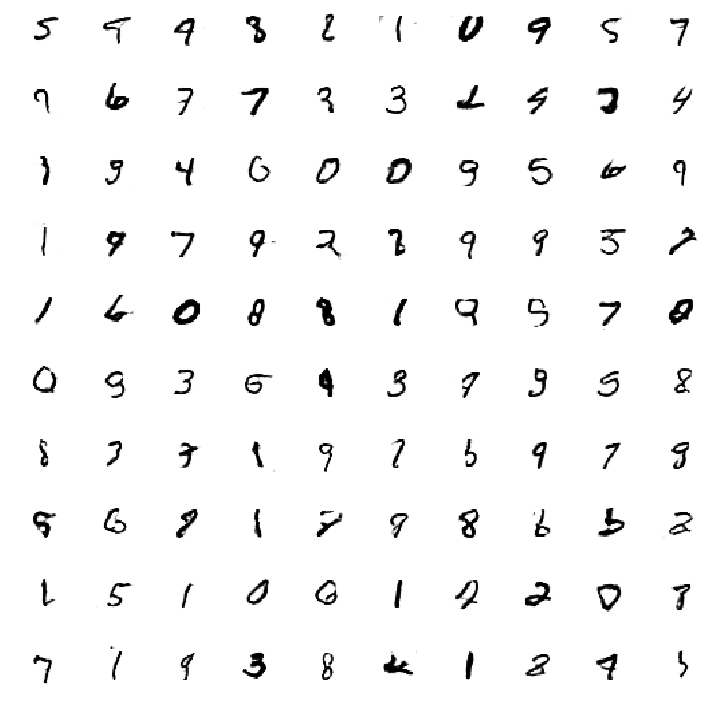

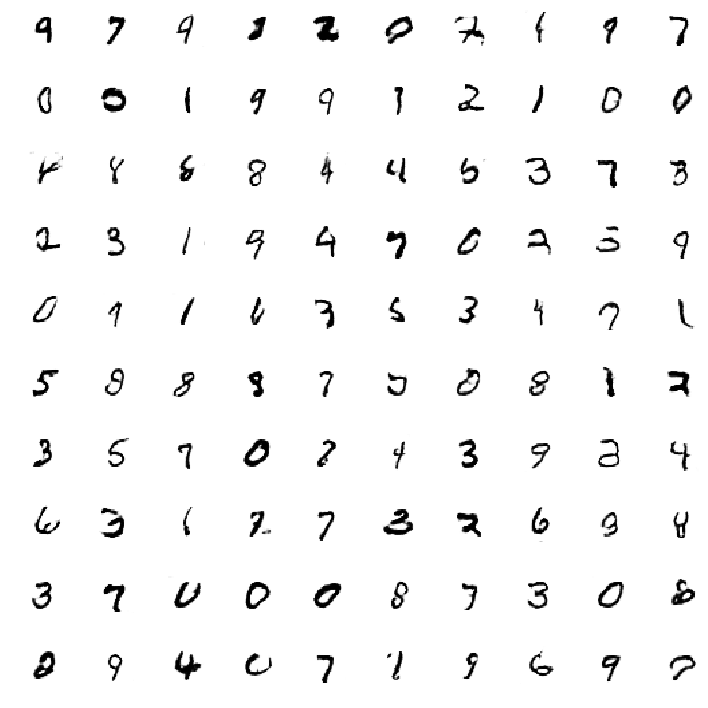

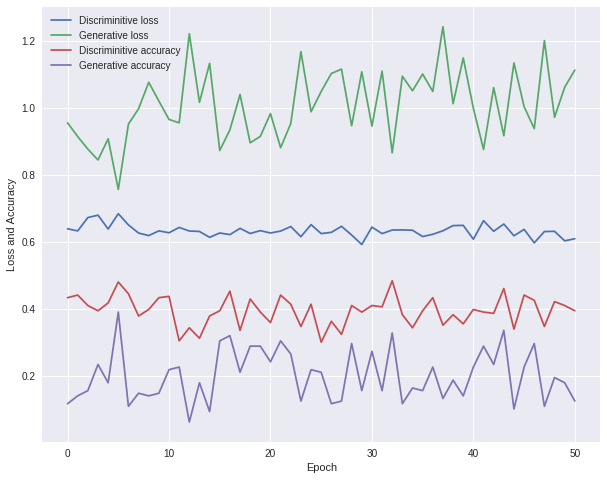

In [12]:
if __name__ == '__main__':
    train(51, 128)
    

-------------NEXT-------------


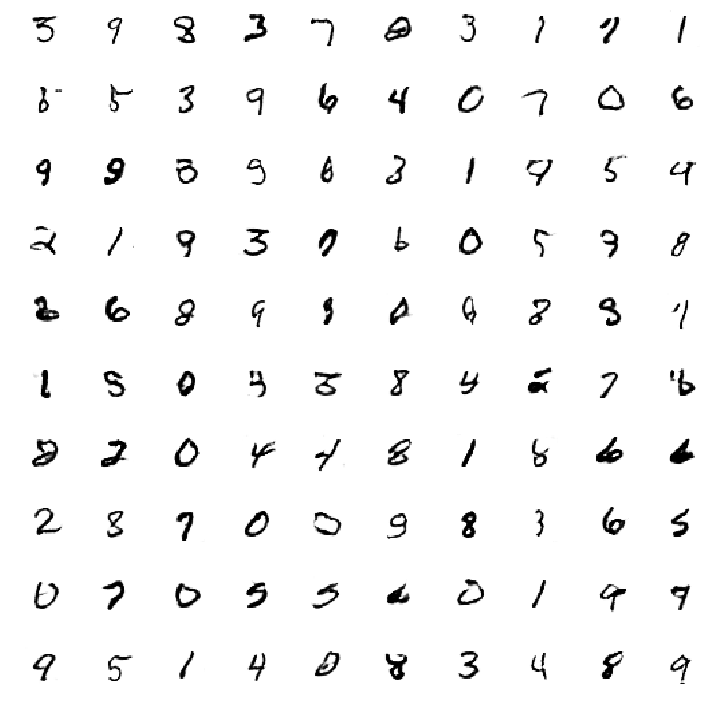

In [20]:
plotGeneratedImages(50)